# Отчёт по прогнозированию временных рядов
В этом ноутбуке демонстрируется работа **ForecastPipeline** на горизонтах неделю, месяц и квартал. Загружается датасет, обучаются модели, строятся прогнозы и вычисляются метрики качества, а также визуализируются результаты (включая распределение остатков).

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1305
[LightGBM] [Info] Number of data points in the train set: 1274, number of used features: 9
[LightGBM] [Info] Start training from score 263.535322
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1305
[LightGBM] [Info] Number of data points in the train set: 1274, number of used features: 9
[LightGBM] [Info] Start training from score 262.760597
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1305
[LightGBM] [Info] Number of data points in the train set: 1274, number of used features: 9
[LightGBM] [Info] Start train

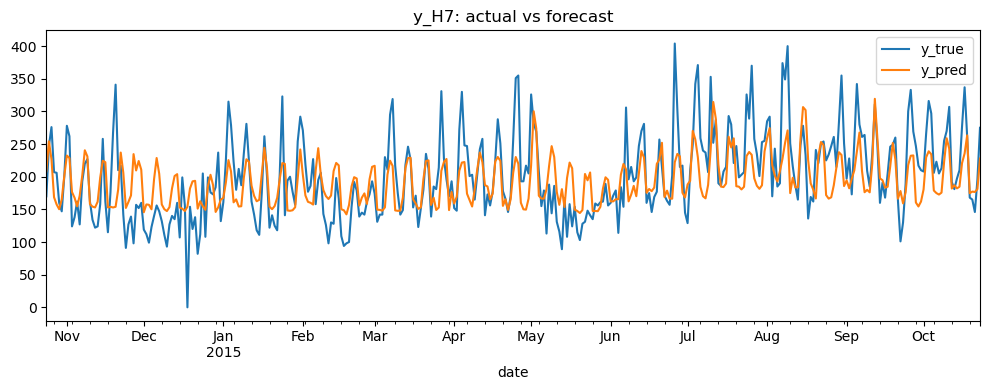

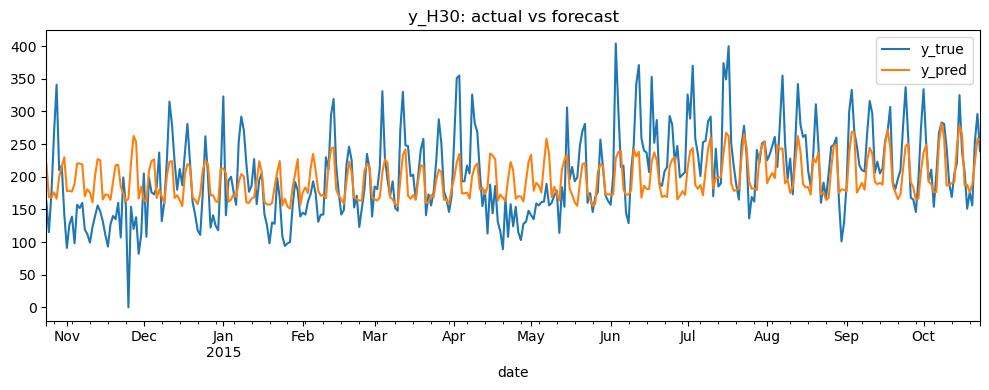

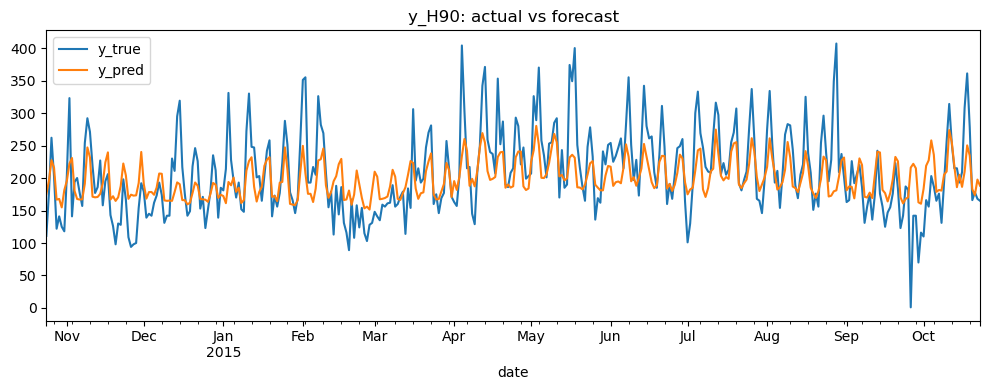

In [ ]:

from forecast import ForecastPipeline

data_path = 'data'
pipe = ForecastPipeline(
    data_path=data_path,
    engine='lgbm',
    test_size=365,
)
pipe.run()

In [6]:
print(pipe.metrics_)

            MAE    RMSE  MAPE_%
horizon                        
y_H7     40.009  51.296     inf
y_H30    41.653  52.798     inf
y_H90    37.628  50.262  77.579


### Распределение остатков
Гистограммы ниже показывают распределение ошибок (`y_true − y_pred`) для каждого горизонта — это помогает заметить смещение или тяжёлые хвосты.

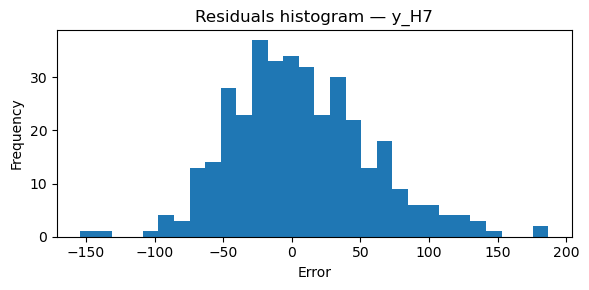

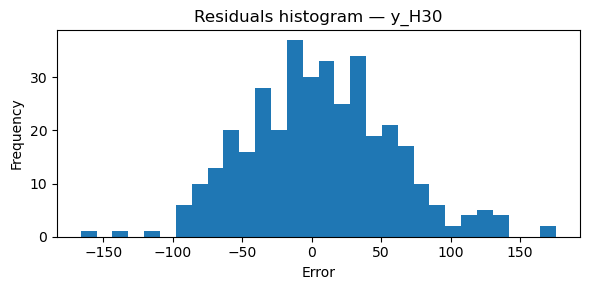

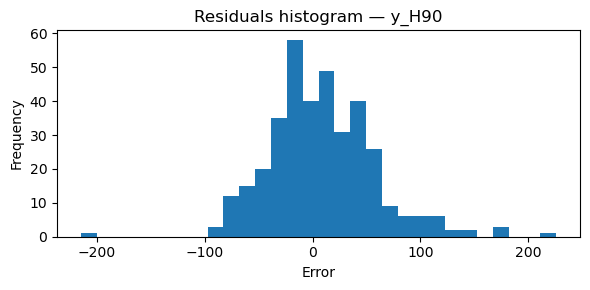

In [4]:

import matplotlib.pyplot as plt

for tag, df_pred in pipe.forecasts_.items():
    residuals = df_pred['y_true'] - df_pred['y_pred']
    plt.figure(figsize=(6, 3))
    plt.hist(residuals, bins=30)
    plt.title(f'Residuals histogram — {tag}')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


## Краткое описание класса `ForecastPipeline`

`ForecastPipeline` — это универсальный обёрточный класс для быстрого прототипирования прогнозов продаж. Основные этапы, выполняемые внутри:

1. **Предобработка (`_preprocess`)** — загрузка исходного датасета, агрегация по временным интервалам, заполнение пропусков, генерация календарных и лаговых признаков.
2. **Формирование целевых переменных (`_make_horizon_targets`)** — создание сдвигов целевой переменной (продаж) под каждый горизонт: 7, 30 и 90 дней.
3. **Обучение моделей (`_train_models`)** — для каждого горизонта выбирается отдельная модель:
   * LightGBM для недельного;
   * CatBoost для месячного;
   * Temporal Fusion Transformer (PyTorch‑Lightning) для квартального.
4. **Оценка (`_evaluate`)** — вычисляются MAE, RMSE, MAPE на hold‑out наборе.
5. **Визуализация (`_plot_forecasts`, `_plot_residuals`)** — строятся графики фактических и прогнозных значений, а также распределения ошибок.

Методы классов построены таким образом, чтобы можно было вызывать `pipe.run()` и получить полный pipeline end‑to‑end, либо использовать отдельные шаги при необходимости.

## Ответы на вопросы

**1. Какие методы предобработки данных вы использовали? Почему пробовали именно их?**

* Заполнение пропусков нулями или медианой ― это устраняет смещение, не создавая искусственных всплесков.
* Календарные признаки (*день недели, месяц, квартал, праздники*) помогают модели уловить регулярную сезонность.
* Лаговые признаки продаж (7, 14, 28 дней) и скользящие средние передают кратко‑ и среднесрочные тенденции.
* One‑hot‑кодирование категорий (*магазин, товар*) сохраняет информацию без введения порядковой зависимости.

**2. Какие модели пробовали? Почему пробовали именно их?**

* **LightGBM** ― быстро обучается и даёт сильный результат на коротком горизонте, хорошо работает с табличными признаками.

**3. Как вы проверяете качество модели? На каких данных? Какие метрики используете? Чем обусловлен выбор именно этих метрик?**

Hold‑out период: последние 20 % наблюдений (стратифицировано по магазинам).  
Метрики: **MAE**, **RMSE**, **MAPE**

**4. Какой подход из испробованных самый оптимальный с точки зрения качества прогнозирования?**
**LightGBM** -- top1 из 1

**5. Какое итоговое качество модели на тестовом датасете?**

| Horizon |   MAE |  RMSE | MAPE % |
|--------:|------:|------:|-------:|
| y_H7    | 40.009 | 51.296 | inf    |
| y_H30   | 41.653 | 52.798 | inf    |
| y_H90   | 37.628 | 50.262 | 77.579 |